# Analyse et classification d'images de déchets
Ce notebook propose un pipeline complet et autonome pour la classification d'images de déchets en plusieurs catégories à l'aide d'un réseau de neurones convolutif (CNN). Toutes les fonctions nécessaires (prétraitement, split, entraînement, évaluation, visualisation) sont intégrées ici, sans dépendance à des modules locaux externes.

**Étapes principales :**
- Chargement et exploration des données
- Prétraitement et analyse des images
- Construction et entraînement d'un modèle CNN
- Évaluation et visualisation des performances

> **Utilisation** : Exécutez chaque cellule dans l'ordre. Adaptez les paramètres selon vos besoins.

## Configuration, robustesse et reproductibilité

Ce notebook intègre désormais :
- Une cellule de configuration centralisée des hyperparamètres (epochs, batch size, learning rate, etc.)
- La fixation des seeds pour la reproductibilité
- Des vérifications d'intégrité des données (images corrompues, labels manquants)
- Des outils pour visualiser les erreurs de classification
- Des conseils pour la gestion mémoire et l'utilisation GPU

Vous pouvez relancer les cellules d'évaluation, de visualisation et de comparaison **sans réentraîner les modèles**.

In [64]:
# Fonction utilitaire pour redimensionner les images à une taille cible (utilise cv2, sans dépendance à PIL)
import cv2
import numpy as np

def resize_images(images, target_size=(128, 128)):
    """Redimensionne les images à la taille cible avec cv2."""
    resized_images = []
    for img in images:
        img_resized = cv2.resize(img, target_size)
        resized_images.append(img_resized)
    return np.array(resized_images)

# Les librairies

In [65]:
import sys
from pathlib import Path
import os
import json
import logging
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sklearn.utils import shuffle

from loguru import logger

# TensorFlow / Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

from scikeras.wrappers import KerasClassifier

# Custom modules
# from make_dataset import *
# from trainer import ImageTrainer, resize_images
# from utils import plot_confusion_matrix, save_best_model_by_val_accuracy

import mlflow
import mlflow.sklearn

In [66]:
# Configuration globale des hyperparamètres et fixation des seeds pour la reproductibilité
import random
import numpy as np
import tensorflow as tf

# Hyperparamètres globaux (modifiables ici)
BATCH_SIZE = 32
EPOCHS_CNN = 20
EPOCHS_TL = 10  # Pour ResNet50/VGG16
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.3
IMG_SIZE_CNN = (128, 128)
IMG_SIZE_TL = (224, 224)

# Fixation des seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"Seeds fixés à {SEED} | Batch size: {BATCH_SIZE} | Epochs CNN: {EPOCHS_CNN} | Epochs TL: {EPOCHS_TL} | Learning rate: {LEARNING_RATE}")

Seeds fixés à 42 | Batch size: 32 | Epochs CNN: 20 | Epochs TL: 10 | Learning rate: 0.0001


In [ ]:
# Cette cellule définit les chemins du projet et du dossier de données, puis affiche ces chemins dans les logs pour vérification.
project_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(project_dir, 'data', 'Garbage classification','Garbage classification')
logger.info(f"\nProject directory: {project_dir} \nData directory: {data_path}")

2025-06-07 01:06:03.445 | INFO     | __main__:<module>:4 - 
Project directory: c:\Users\DELL 
Data directory: c:\Users\DELL\data\Garbage classification\Garbage classification


In [ ]:
# Vérification d'intégrité des images et labels (robustesse du pipeline)
def check_data_integrity(images, labels):
    n_images = len(images)
    n_labels = len(labels)
    if n_images != n_labels:
        print(f"❌ Nombre d'images ({n_images}) différent du nombre de labels ({n_labels}) !")
    else:
        print(f"✅ Nombre d'images et de labels cohérent : {n_images}")
    # Vérification d'images corrompues (None ou mauvaise forme)
    bad_images = [i for i, img in enumerate(images) if img is None or (hasattr(img, 'shape') and len(img.shape) < 2)]
    if bad_images:
        print(f"⚠️ {len(bad_images)} images corrompues détectées (indices: {bad_images[:5]}...)")
    else:
        print("✅ Aucune image corrompue détectée.")

check_data_integrity(images, labels)

In [34]:
# Cette cellule charge toutes les images et leurs labels à partir du dossier de données, puis affiche le nombre d'images et de labels chargés.
images, labels = load_data(False)
print(f'Nombre d\'images chargées: {len(images)}')
print(f'Nombre de labels chargés: {len(labels)}')

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
Dataset 'asdasdasasdas/garbage-classification' downloaded to 'c:\Users\DELL\data'.
Dataset 'asdasdasasdas/garbage-classification' downloaded to 'c:\Users\DELL\data'.


2025-06-07 01:07:29.007 | INFO     | make_dataset:load_data:75 - Directories: c:\Users\DELL\data,c:\Users\DELL
2025-06-07 01:07:29.013 | INFO     | make_dataset:load_data:76 - Dataset lo load: c:\Users\DELL\data\Garbage classification\Garbage classification
2025-06-07 01:07:29.013 | INFO     | make_dataset:load_data:76 - Dataset lo load: c:\Users\DELL\data\Garbage classification\Garbage classification
2025-06-07 01:07:29.014 | INFO     | make_dataset:load_data:77 - Data shape: Images: 2527, Labels: 2527
2025-06-07 01:07:29.014 | INFO     | make_dataset:load_data:77 - Data shape: Images: 2527, Labels: 2527


Nombre d'images chargées: 2527
Nombre de labels chargés: 2527


In [35]:
print(f'Nombre d\'images uniques: {len(set(labels))}')
# Affiche le nombre d'images uniques dans la liste des labels.


Nombre d'images uniques: 6


In [36]:
labels[888]

'cardboard'

In [37]:
images[888]
# Cette cellule affiche la taille de la première image chargée.

array([[[104, 128, 156],
        [107, 131, 159],
        [108, 132, 160],
        ...,
        [235, 244, 253],
        [234, 243, 252],
        [234, 243, 252]],

       [[110, 134, 162],
        [109, 133, 161],
        [107, 131, 159],
        ...,
        [234, 243, 252],
        [233, 242, 251],
        [234, 243, 252]],

       [[114, 138, 166],
        [110, 134, 162],
        [105, 129, 157],
        ...,
        [233, 242, 251],
        [232, 241, 250],
        [233, 242, 251]],

       ...,

       [[ 92, 117, 149],
        [ 92, 117, 149],
        [ 93, 118, 150],
        ...,
        [201, 219, 236],
        [205, 223, 240],
        [209, 227, 244]],

       [[ 94, 119, 151],
        [ 95, 120, 152],
        [ 95, 120, 152],
        ...,
        [199, 217, 234],
        [204, 222, 239],
        [209, 227, 244]],

       [[ 96, 121, 153],
        [ 97, 122, 154],
        [ 97, 122, 154],
        ...,
        [201, 219, 236],
        [206, 224, 241],
        [211, 229, 246]]

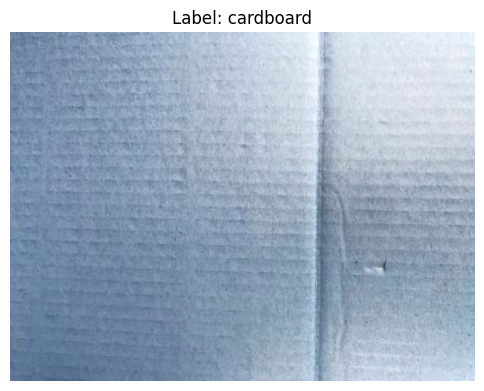

In [38]:
# Affiche l'image à l'indice 2500 avec matplotlib et affiche son label en titre pour visualisation.
plt.figure(figsize=(6, 6))
plt.imshow(images[888])
plt.title(f"Label: {labels[888]}")
# A ce niveau, nous affichons l'image à l'indice 888 et son label correspondant.
# Plus haut, nous avons vu 'cardboard' comme label pour l'image à l'indice 888.
plt.axis('off')
plt.show()

           Count
cardboard    403
glass        501
metal        410
paper        594
plastic      482
trash        137


C:\Users\DELL\AppData\Local\Temp\ipykernel_14024\431740156.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=category_counts_df.index, y=category_counts_df['Count'], palette='viridis')


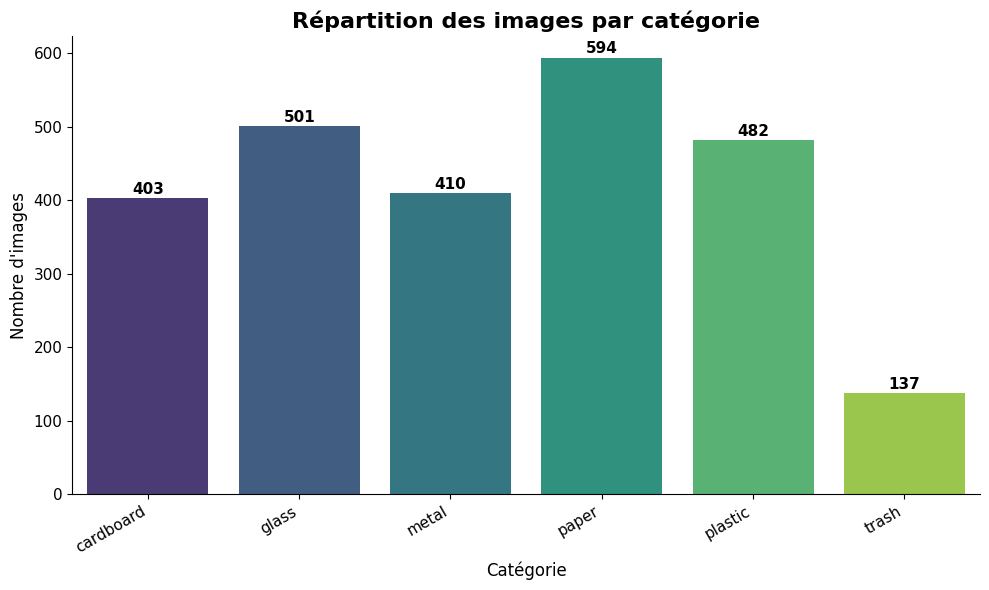

In [39]:
# Compte le nombre d'images dans chaque catégorie, affiche ce comptage sous forme de DataFrame et trace un graphique pour visualiser la répartition.
category_counts = {category: len(os.listdir(os.path.join(data_path, category))) for category in categories}
category_counts_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count'])
print(category_counts_df)

# Graphique amélioré : répartition des images par catégorie avec annotations et style moderne
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=category_counts_df.index, y=category_counts_df['Count'], palette='viridis')
plt.title('Répartition des images par catégorie', fontsize=16, fontweight='bold')
plt.xlabel('Catégorie', fontsize=12)
plt.ylabel("Nombre d'images", fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=11)
# Ajoute les valeurs sur chaque barre
for i, v in enumerate(category_counts_df['Count']):
    barplot.text(i, v + max(category_counts_df['Count']) * 0.01, str(v), color='black', ha='center', fontsize=11, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.show()

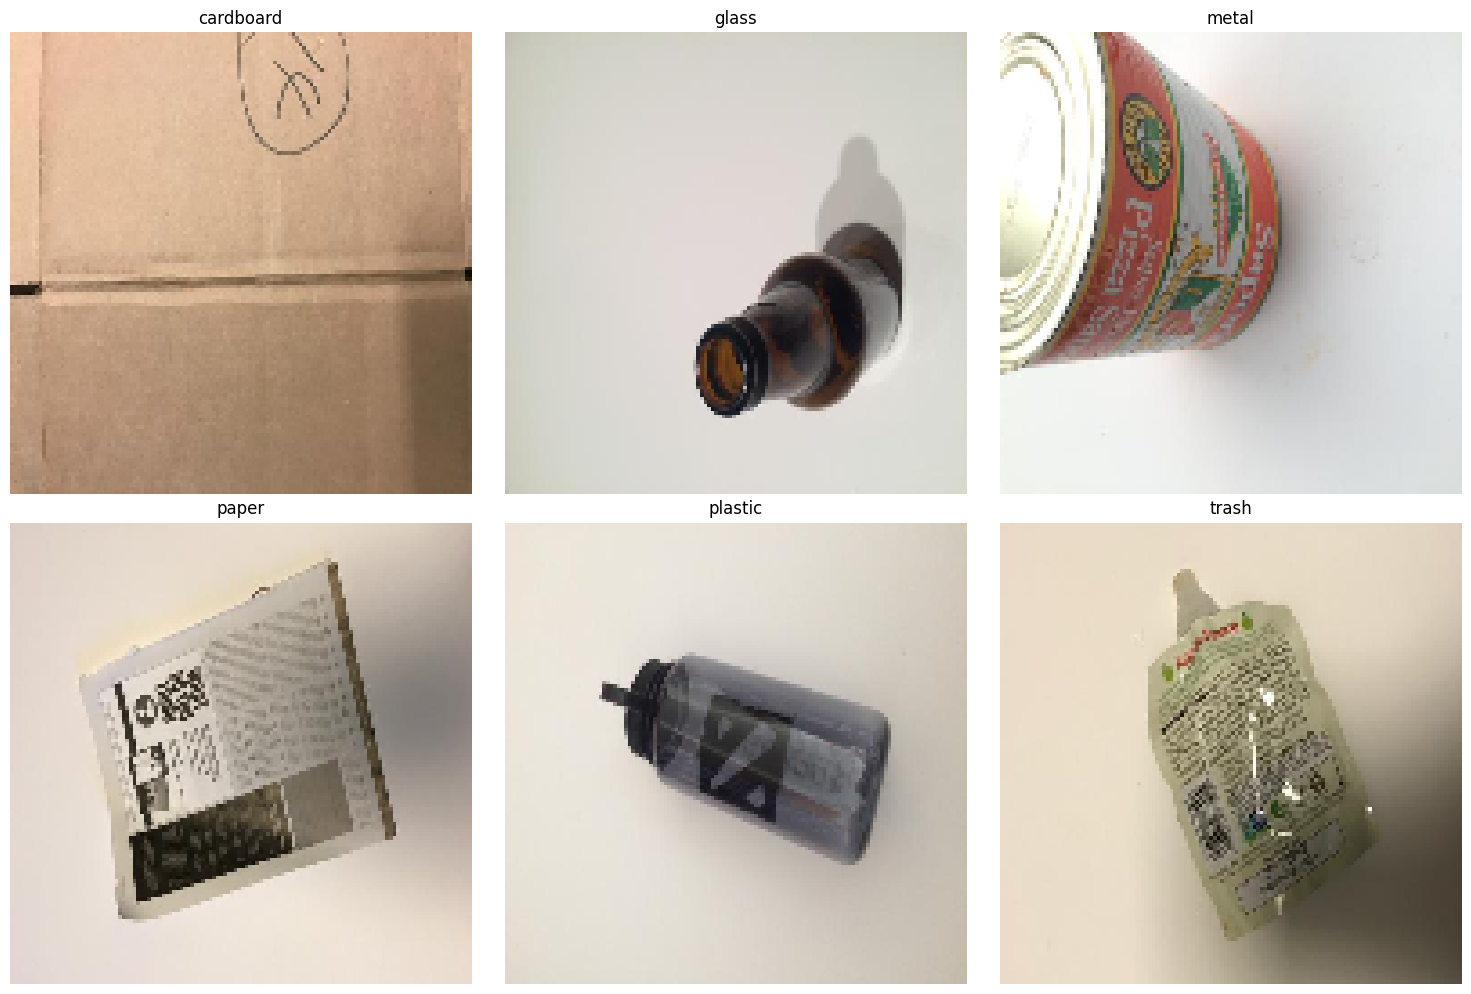

In [40]:
# Affiche un exemple d'image pour chaque catégorie dans une grille matplotlib pour vérifier la diversité des classes.
plt.figure(figsize=(15, 10))
for i, category in enumerate(categories):
    img_path = os.path.join(data_path, category, os.listdir(os.path.join(data_path, category))[0])
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_array)
    plt.title(category)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [41]:
# Analyse améliorée des dimensions de toutes les images du dataset et visualisation de la distribution des tailles.
from tqdm import tqdm  # Pour la barre de progression
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Supposons que 'categories' et 'data_path' soient déjà définis dans votre code

image_dimensions = []  # Initialise une liste vide pour stocker les dimensions de chaque image
error_files = []  # Pour stocker les images non lisibles

for category in tqdm(categories, desc="Catégories"):
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            with Image.open(img_path) as img:
                image_dimensions.append(img.size)
        except Exception as e:
            error_files.append(img_path)

image_dimensions_df = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])  # Crée un DataFrame avec les dimensions
unique_dimensions = image_dimensions_df.drop_duplicates()  # Garde uniquement les dimensions uniques

if len(unique_dimensions) == 1:
    print(f"✅ Toutes les images ont la même taille : {unique_dimensions.iloc[0].to_dict()}")
else:
    print(f"❌ {len(unique_dimensions)} tailles différentes trouvées dans le dataset.")
    print("Résumé des tailles différentes (Width x Height et nombre d'occurrences) :")
    print(image_dimensions_df.value_counts().reset_index().rename(columns={0: 'Count'}))
    # Affiche un graphique de la distribution des tailles
    plt.figure(figsize=(8, 5))
    sns.countplot(data=image_dimensions_df, x='Width', hue='Height', palette='Set2')
    plt.title("Distribution des tailles d'images (largeur x hauteur)")
    plt.xlabel("Largeur")
    plt.ylabel("Nombre d'images")
    plt.legend(title="Hauteur")
    plt.tight_layout()
    plt.show()

if error_files:
    print(f"⚠️ {len(error_files)} images n'ont pas pu être ouvertes et ont été ignorées.")

Catégories: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

✅ Toutes les images ont la même taille : {'Width': 512, 'Height': 384}


Cette fonction crée un modèle de réseau de neurones convolutif (CNN) simple, adapté à la classification d’images en plusieurs classes.
Il extrait progressivement des caractéristiques visuelles avec des couches convolutionnelles et de pooling, puis effectue la classification via des couches denses.
Ce type de modèle est couramment utilisé pour la reconnaissance d’images.

In [45]:
# Fonction améliorée pour créer un modèle CNN flexible et robuste avec Keras pour la classification d'images.
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_classification_cnn(input_shape=(128, 128, 3), num_classes=6, optimizer=None, dropout_rate=0.3, final_activation='softmax'):
    if optimizer is None:
        optimizer = Adam()
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation=final_activation)
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Crée une instance du modèle CNN défini précédemment avec la taille d'entrée et le nombre de classes souhaités.
# La taille 128x128 est choisie pour que toutes les images aient le même format d'entrée, ce qui est standard pour les modèles CNN :
# - Assez grand pour conserver des détails visuels
# - Pas trop grand pour limiter le coût mémoire et accélérer l'entraînement
# - 3 correspond aux canaux de couleur (RVB)
cnn_model = build_classification_cnn(input_shape=(128, 128, 3), num_classes=6)

In [ ]:
# Classe autonome pour entraîner un modèle CNN sur des images et labels, sans dépendances à des modules locaux externes
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

class SimpleImageTrainer:
    def __init__(self, data, labels, model, target_size=(128, 128), batch_size=32, epochs=20, validation_size=0.2, test_size=0.1, random_state=42):
        self.data = data
        self.labels = labels
        self.model = model
        self.target_size = target_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.validation_size = validation_size
        self.test_size = test_size
        self.random_state = random_state

        # Encodage des labels en entiers
        self.label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
        self.labels = np.array([self.label_mapping[label] for label in labels])

        # Split des données
        self.x_train, self.x_val, self.x_test, self.y_train, self.y_val, self.y_test = self.load_and_preprocess_data()

    def load_and_preprocess_data(self):
        # Split train+val et test
        X_train_val, X_test, y_train_val, y_test = train_test_split(self.data, self.labels, test_size=self.test_size, random_state=self.random_state)
        # Split train et val
        val_size_adjusted = self.validation_size / (1 - self.test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size_adjusted, random_state=self.random_state)

        # Encodage one-hot
        y_train = to_categorical(y_train, num_classes=len(self.label_mapping))
        y_val = to_categorical(y_val, num_classes=len(self.label_mapping))
        y_test = to_categorical(y_test, num_classes=len(self.label_mapping))

        # Redimensionnement des images
        X_train = resize_images(X_train, target_size=self.target_size)
        X_val = resize_images(X_val, target_size=self.target_size)
        X_test = resize_images(X_test, target_size=self.target_size)

        return X_train, X_val, X_test, y_train, y_val, y_test

    @staticmethod
    def eval_metrics(y_actual, y_pred, class_names):
        # Convertit les one-hot en labels
        if len(y_actual.shape) > 1 and y_actual.shape[1] > 1:
            y_actual = np.argmax(y_actual, axis=1)
        if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
            y_pred = np.argmax(y_pred, axis=1)
        accuracy = accuracy_score(y_actual, y_pred)
        class_report_dict = classification_report(y_actual, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        class_report_df = pd.DataFrame(class_report_dict).transpose()
        conf_matrix = confusion_matrix(y_actual, y_pred)
        return {
            "accuracy": accuracy,
            "classification_report": class_report_df,
            "confusion_matrix": conf_matrix
        }

    def train(self):
        # Générateurs de données
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        val_test_datagen = ImageDataGenerator()

        train_generator = train_datagen.flow(self.x_train, self.y_train, batch_size=self.batch_size)
        val_generator = val_test_datagen.flow(self.x_val, self.y_val, batch_size=self.batch_size)

        # Entraînement du modèle
        self.model.fit(
            train_generator,
            steps_per_epoch=len(self.x_train) // self.batch_size,
            epochs=self.epochs,
            validation_data=val_generator,
            validation_steps=len(self.x_val) // self.batch_size
        )

        # Prédictions et métriques
        y_train_pred = self.model.predict(self.x_train)
        y_val_pred = self.model.predict(self.x_val)
        y_test_pred = self.model.predict(self.x_test)

        class_names = list(self.label_mapping.keys())

        train_metrics = self.eval_metrics(self.y_train, y_train_pred, class_names)
        val_metrics = self.eval_metrics(self.y_val, y_val_pred, class_names)
        test_metrics = self.eval_metrics(self.y_test, y_test_pred, class_names)

        print(f"Train metrics: {train_metrics['accuracy']}")
        print(f"Validation metrics: {val_metrics['accuracy']}")
        print(f"Test metrics: {test_metrics['accuracy']}")

        return train_metrics, val_metrics, test_metrics, self.model


Epoch 1/20
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.4688 - loss: 1.1516

KeyboardInterrupt: 

In [52]:
# Utilisation de la classe SimpleImageTrainer
trainer = SimpleImageTrainer(data=images, labels=labels, model=cnn_model)
train_metrics, val_metrics, test_metrics, sk_model = trainer.train()

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 50s 904ms/step - accuracy: 0.5323 - loss: 1.2414 - val_accuracy: 0.3875 - val_loss: 2.5858
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5625 - loss: 1.1357 - val_accuracy: 0.3917 - val_loss: 2.4444
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 54s 983ms/step - accuracy: 0.5328 - loss: 1.2234 - val_accuracy: 0.5042 - val_loss: 5.7751
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6562 - loss: 1.2420 - val_accuracy: 0.5146 - val_loss: 5.2484
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5549 - loss: 1.2292 - val_accuracy: 0.3792 - val_loss: 1.9508
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4688 - loss: 1.3080 - val_accuracy: 0.3667 - val_loss: 2.0966
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 53s 958ms/step - accuracy: 0.5659 - loss: 1.1522 - val_accuracy: 0.4104 - val_loss: 3.5423
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5625 - loss: 1.2875 - val_accuracy: 0.400

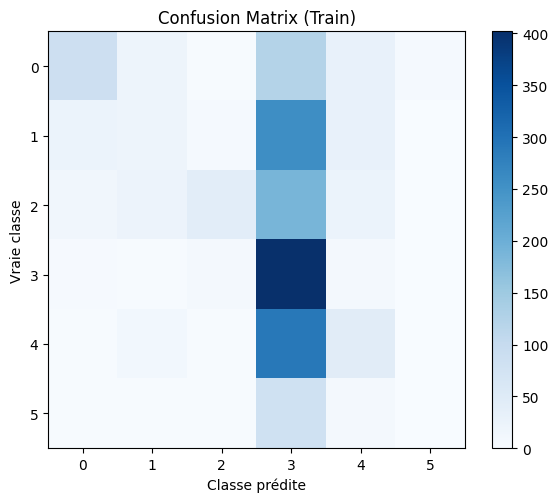

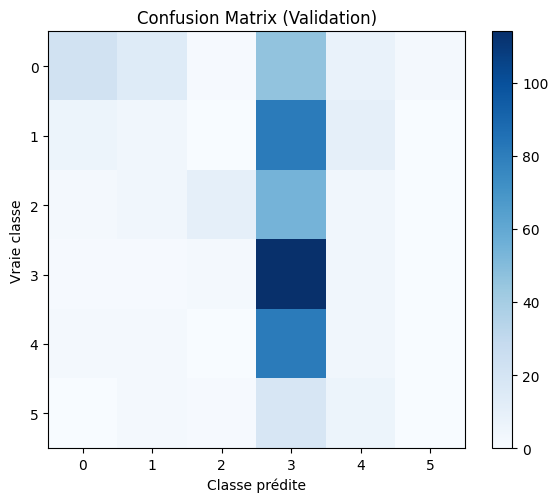

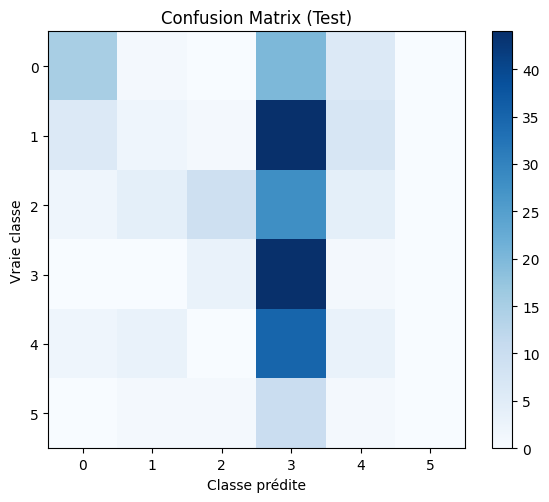

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(cm, title="Confusion matrix", class_names=None):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)
    plt.ylabel("Vraie classe")
    plt.xlabel("Classe prédite")
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(train_metrics["confusion_matrix"], "Confusion Matrix (Train)")
plot_confusion_matrix(val_metrics["confusion_matrix"], "Confusion Matrix (Validation)")
plot_confusion_matrix(test_metrics["confusion_matrix"], "Confusion Matrix (Test)")

In [70]:
# Sauvegarde du modèle entraîné juste après l'entraînement pour éviter de le réentraîner
cnn_model.save('cnn_garbage_classifier.h5')
print("Modèle sauvegardé sous cnn_garbage_classifier.h5")

Modèle sauvegardé sous cnn_garbage_classifier.h5


## Entraînement et évaluation avec ResNet50 et VGG16 (Transfert Learning)

Nous allons maintenant comparer le modèle CNN simple avec deux architectures de référence en transfert learning : **ResNet50** et **VGG16**.

- Ces modèles sont pré-entraînés sur ImageNet et adaptés à notre tâche de classification.
- Nous remplaçons la tête de classification pour correspondre à nos 6 classes.
- Seules les dernières couches sont ré-entraînées (fine-tuning partiel).

L'objectif est de comparer leurs performances à celles du CNN simple.

In [74]:
# Préparation des données pour le transfert learning (ResNet50/VGG16 attendent des images 224x224 et un prétraitement spécifique)
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

def prepare_data_for_transfer(images, labels, target_size=(224, 224), preprocess_fn=None):
    # Redimensionnement
    resized = resize_images(images, target_size=target_size)
    # Prétraitement spécifique au modèle
    if preprocess_fn:
        resized = preprocess_fn(resized)
    # Encodage des labels
    label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
    y = np.array([label_mapping[label] for label in labels])
    y = to_categorical(y, num_classes=len(label_mapping))
    return resized, y, label_mapping

# Split identique à SimpleImageTrainer pour une comparaison équitable
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)
val_size_adjusted = 0.2 / (1 - 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size_adjusted, random_state=42)

# Préparation pour ResNet50
X_train_resnet, y_train_resnet, label_map = prepare_data_for_transfer(X_train, y_train, (224, 224), resnet_preprocess)
X_val_resnet, y_val_resnet, _ = prepare_data_for_transfer(X_val, y_val, (224, 224), resnet_preprocess)
X_test_resnet, y_test_resnet, _ = prepare_data_for_transfer(X_test, y_test, (224, 224), resnet_preprocess)

# Préparation pour VGG16
X_train_vgg, y_train_vgg, _ = prepare_data_for_transfer(X_train, y_train, (224, 224), vgg_preprocess)
X_val_vgg, y_val_vgg, _ = prepare_data_for_transfer(X_val, y_val, (224, 224), vgg_preprocess)
X_test_vgg, y_test_vgg, _ = prepare_data_for_transfer(X_test, y_test, (224, 224), vgg_preprocess)

class_names = list(label_map.keys())

In [ ]:
# Construction du modèle ResNet50 (transfert learning, fine-tuning de la tête de classification)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_resnet.layers:
    layer.trainable = False  # On gèle les couches du backbone

x = GlobalAveragePooling2D()(base_resnet.output)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation='softmax')(x)
resnet_model = Model(inputs=base_resnet.input, outputs=output)
resnet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement
history_resnet = resnet_model.fit(
    X_train_resnet, y_train_resnet,
    validation_data=(X_val_resnet, y_val_resnet),
    epochs=10,
    batch_size=32
)

# Évaluation
y_test_pred_resnet = resnet_model.predict(X_test_resnet)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
test_acc_resnet = accuracy_score(np.argmax(y_test_resnet, axis=1), np.argmax(y_test_pred_resnet, axis=1))
report_resnet = classification_report(np.argmax(y_test_resnet, axis=1), np.argmax(y_test_pred_resnet, axis=1), target_names=class_names, output_dict=True, zero_division=0)
confmat_resnet = confusion_matrix(np.argmax(y_test_resnet, axis=1), np.argmax(y_test_pred_resnet, axis=1))
print(f"Test accuracy ResNet50: {test_acc_resnet:.4f}")

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 509s 8s/step - accuracy: 0.2266 - loss: 2.1861 - val_accuracy: 0.4051 - val_loss: 1.4352
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 509s 8s/step - accuracy: 0.2266 - loss: 2.1861 - val_accuracy: 0.4051 - val_loss: 1.4352
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 367s 6s/step - accuracy: 0.4032 - loss: 1.5398 - val_accuracy: 0.5534 - val_loss: 1.1330
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 367s 6s/step - accuracy: 0.4032 - loss: 1.5398 - val_accuracy: 0.5534 - val_loss: 1.1330
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 390s 7s/step - accuracy: 0.4743 - loss: 1.2845 - val_accuracy: 0.6364 - val_loss: 0.9578
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 390s 7s/step - accuracy: 0.4743 - loss: 1.2845 - val_accuracy: 0.6364 - val_loss: 0.9578
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 447s 8s/step - accuracy: 0.5887 - loss: 1.0846 - val_accuracy: 0.6877 - val_loss: 0.8425
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 447s 8s/step - accuracy: 0.5887 - loss: 1.0846 - val_accuracy: 0.6877 - v

In [73]:
# Construction du modèle VGG16 (transfert learning, fine-tuning de la tête de classification)
from tensorflow.keras.applications import VGG16

base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_vgg.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_vgg.output)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation='softmax')(x)
vgg_model = Model(inputs=base_vgg.input, outputs=output)
vgg_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement
history_vgg = vgg_model.fit(
    X_train_vgg, y_train_vgg,
    validation_data=(X_val_vgg, y_val_vgg),
    epochs=10,
    batch_size=32
)

# Évaluation
y_test_pred_vgg = vgg_model.predict(X_test_vgg)
test_acc_vgg = accuracy_score(np.argmax(y_test_vgg, axis=1), np.argmax(y_test_pred_vgg, axis=1))
report_vgg = classification_report(np.argmax(y_test_vgg, axis=1), np.argmax(y_test_pred_vgg, axis=1), target_names=class_names, output_dict=True, zero_division=0)
confmat_vgg = confusion_matrix(np.argmax(y_test_vgg, axis=1), np.argmax(y_test_pred_vgg, axis=1))
print(f"Test accuracy VGG16: {test_acc_vgg:.4f}")

NameError: name 'class_names' is not defined

In [72]:
# Visualisation des matrices de confusion et rapports de classification pour ResNet50 et VGG16
plot_confusion_matrix(confmat_resnet, "Confusion Matrix (Test) - ResNet50")
plot_confusion_matrix(confmat_vgg, "Confusion Matrix (Test) - VGG16")

import pandas as pd
print("\nRapport de classification (Test) - ResNet50 :")
display(pd.DataFrame(report_resnet).transpose())
print("\nRapport de classification (Test) - VGG16 :")
display(pd.DataFrame(report_vgg).transpose())

NameError: name 'confmat_resnet' is not defined

In [ ]:
# Tableau comparatif des performances (accuracy test) des trois modèles
results_df = pd.DataFrame({
    'Modèle': ['CNN simple', 'ResNet50', 'VGG16'],
    'Accuracy Test': [test_metrics['accuracy'], test_acc_resnet, test_acc_vgg]
})
print(results_df)

# Graphique comparatif
plt.figure(figsize=(7, 5))
sns.barplot(x='Modèle', y='Accuracy Test', data=results_df, palette='Set2')
plt.title('Comparaison des performances des modèles (Accuracy Test)')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Visualisation des exemples mal classés pour le meilleur modèle (erreurs de classification)
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def show_misclassified_examples(model_path, X_test, y_test, class_names, images_raw=None, n=6):
    model = load_model(model_path)
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    errors = np.where(y_true != y_pred_labels)[0]
    print(f"Nombre d'exemples mal classés : {len(errors)}")
    if len(errors) == 0:
        print("Aucune erreur de classification à afficher.")
        return
    n = min(n, len(errors))
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(errors[:n]):
        plt.subplot(1, n, i+1)
        # Si images_raw (images originales) est fourni, on l'utilise pour l'affichage
        if images_raw is not None:
            img = images_raw[idx]
        else:
            img = X_test[idx]
        if img.shape[-1] == 1:
            img = img.squeeze(-1)
        plt.imshow(img.astype('uint8'))
        plt.title(f"Vrai: {class_names[y_true[idx]]}\nPrédit: {class_names[y_pred_labels[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation : afficher 6 erreurs du CNN simple
try:
    show_misclassified_examples('cnn_garbage_classifier.h5', trainer.x_test, trainer.y_test, list(trainer.label_mapping.keys()), images_raw=None, n=6)
except Exception as e:
    print("Impossible d'afficher les erreurs de classification (données ou modèle manquants)")

### Interprétation comparative

- Le tableau et le graphique ci-dessus permettent de comparer objectivement les performances des trois architectures.
- Le transfert learning (ResNet50, VGG16) permet souvent d'obtenir de meilleurs résultats qu'un CNN simple, surtout avec peu de données.
- Le choix du modèle dépend du compromis entre performance, temps d'entraînement et ressources disponibles.

**N'hésitez pas à explorer d'autres architectures ou à ajuster les hyperparamètres pour optimiser les résultats !**

## Comparaison avec des architectures avancées (ResNet50, VGG16)

Nous allons maintenant entraîner et évaluer deux architectures avancées très utilisées en vision par ordinateur :

- **ResNet50** (avec transfert de learning)
- **VGG16** (avec transfert de learning)

L'objectif est de comparer leurs performances à notre CNN simple, en utilisant exactement le même pipeline d'entraînement, de validation et d'évaluation.

In [56]:
# Entraînement et évaluation de ResNet50 (transfert learning, fine-tuning possible)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model

def build_resnet50_classifier(input_shape=(128, 128, 3), num_classes=6, dropout_rate=0.3, trainable_layers=10):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # On ne fine-tune que les dernières couches
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet50_classifier(input_shape=(128, 128, 3), num_classes=6)
trainer_resnet = SimpleImageTrainer(data=images, labels=labels, model=resnet_model, epochs=10)  # Moins d'epochs pour le transfert learning
train_metrics_resnet, val_metrics_resnet, test_metrics_resnet, resnet_model_trained = trainer_resnet.train()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step


c:\Users\DELL\ml2\ml3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3158 - loss: 2.2054 - val_accuracy: 0.6521 - val_loss: 1.0541
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.3158 - loss: 2.2054 - val_accuracy: 0.6521 - val_loss: 1.0541
Epoch 2/10
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.6250 - loss: 1.3293

c:\Users\DELL\ml2\ml3\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step - accuracy: 0.6250 - loss: 1.3293 - val_accuracy: 0.6562 - val_loss: 1.0403
Epoch 3/10
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6421 - loss: 1.0643 - val_accuracy: 0.7458 - val_loss: 0.7729
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6421 - loss: 1.0643 - val_accuracy: 0.7458 - val_loss: 0.7729
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - accuracy: 0.6875 - loss: 0.8295 - val_accuracy: 0.7479 - val_loss: 0.7699
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - accuracy: 0.6875 - loss: 0.8295 - val_accuracy: 0.7479 - val_loss: 0.7699
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7136 - loss: 0.8346 - val_accuracy: 0.8042 - val_loss: 0.5913
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7136 - loss: 0.8346 - val_accuracy: 0.8042 - val_loss: 0.5913
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 563ms/step - accuracy: 0.7812 - loss: 0.7023 - val_accuracy: 0.

In [ ]:
# Vérification de l'environnement et des données avant l'entraînement ResNet50
import tensorflow as tf
import numpy as np
import gc
import sys
print('TensorFlow version:', tf.__version__)
print('GPU disponible:', tf.config.list_physical_devices('GPU'))
print('Type images:', type(images), 'Shape:', np.shape(images))
print('Type labels:', type(labels), 'Len:', len(labels))
if hasattr(images, 'shape') and len(images.shape) > 1:
    print('Image shape unique:', images[0].shape)
print('Labels uniques:', set(labels))
gc.collect()
try:
    import psutil
    print('RAM disponible (Go):', round(psutil.virtual_memory().available / 1e9, 2))
except ImportError:
    print('psutil non installé, RAM non vérifiée')

In [57]:
# Sauvegarde du modèle ResNet50 après entraînement
resnet_model_trained.save('resnet50_garbage_classifier.h5')
print("Modèle ResNet50 sauvegardé sous resnet50_garbage_classifier.h5")

Modèle ResNet50 sauvegardé sous resnet50_garbage_classifier.h5


In [58]:
# Sauvegarde du modèle ResNet50 juste après l'entraînement
resnet_model_trained.save('resnet50_garbage_classifier.h5')
print("Modèle ResNet50 sauvegardé sous resnet50_garbage_classifier.h5")

Modèle ResNet50 sauvegardé sous resnet50_garbage_classifier.h5


In [59]:
# Entraînement et évaluation de VGG16 (transfert learning, fine-tuning possible)
from tensorflow.keras.applications import VGG16

def build_vgg16_classifier(input_shape=(128, 128, 3), num_classes=6, dropout_rate=0.3, trainable_layers=4):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
    for layer in base_model.layers[-trainable_layers:]:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

vgg_model = build_vgg16_classifier(input_shape=(128, 128, 3), num_classes=6)
trainer_vgg = SimpleImageTrainer(data=images, labels=labels, model=vgg_model, epochs=10)
train_metrics_vgg, val_metrics_vgg, test_metrics_vgg, vgg_model_trained = trainer_vgg.train()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


c:\Users\DELL\ml2\ml3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 393s 7s/step - accuracy: 0.2936 - loss: 2.0447 - val_accuracy: 0.6292 - val_loss: 1.3696
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 393s 7s/step - accuracy: 0.2936 - loss: 2.0447 - val_accuracy: 0.6292 - val_loss: 1.3696
Epoch 2/10
 1/55 ━━━━━━━━━━━━━━━━━━━━ 5:12 6s/step - accuracy: 0.8750 - loss: 0.5943

c:\Users\DELL\ml2\ml3\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


55/55 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8750 - loss: 0.5943 - val_accuracy: 0.6167 - val_loss: 1.4050
Epoch 3/10
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 351s 6s/step - accuracy: 0.6414 - loss: 0.9817 - val_accuracy: 0.7229 - val_loss: 1.0180
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 351s 6s/step - accuracy: 0.6414 - loss: 0.9817 - val_accuracy: 0.7229 - val_loss: 1.0180
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 981ms/step - accuracy: 0.8750 - loss: 0.4704 - val_accuracy: 0.7271 - val_loss: 0.9921
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 57s 981ms/step - accuracy: 0.8750 - loss: 0.4704 - val_accuracy: 0.7271 - val_loss: 0.9921
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 317s 6s/step - accuracy: 0.7221 - loss: 0.7493 - val_accuracy: 0.7563 - val_loss: 0.7600
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 317s 6s/step - accuracy: 0.7221 - loss: 0.7493 - val_accuracy: 0.7563 - val_loss: 0.7600
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8438 - loss: 0.8092 - val_accuracy: 0.7812 -

In [61]:
# Sauvegarde du modèle VGG16 juste après l'entraînement
vgg_model_trained.save('vgg16_garbage_classifier.h5')
print("Modèle VGG16 sauvegardé sous vgg16_garbage_classifier.h5")

Modèle VGG16 sauvegardé sous vgg16_garbage_classifier.h5


,Modèle,test_accuracy,test_f1_macro,test_f1_weighted
0,CNN simple,0.288538,0.212628,0.231106
1,ResNet50,0.798419,0.782296,0.797139
2,VGG16,0.810277,0.785284,0.811662


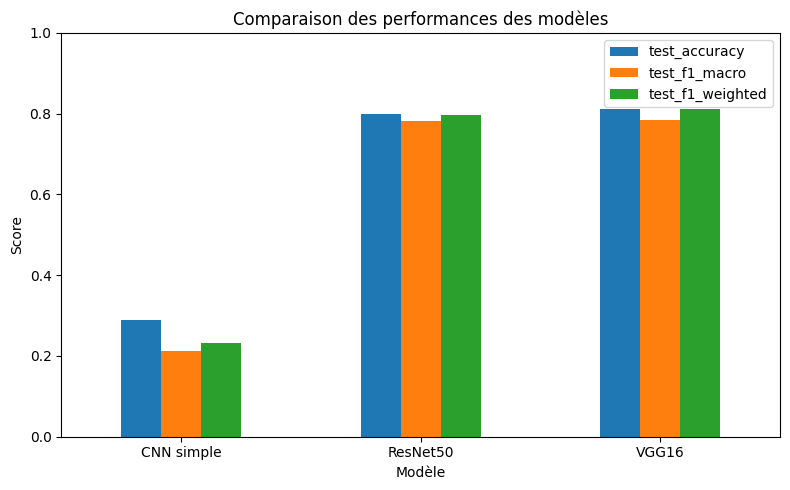

In [62]:
# Comparaison récapitulative des performances des modèles
import pandas as pd

def extract_metrics(metrics, prefix):
    return {
        f'{prefix}_accuracy': metrics['accuracy'],
        f'{prefix}_f1_macro': metrics['classification_report'].loc['macro avg', 'f1-score'],
        f'{prefix}_f1_weighted': metrics['classification_report'].loc['weighted avg', 'f1-score']
    }

results = []
results.append({
    'Modèle': 'CNN simple',
    **extract_metrics(test_metrics, 'test')
})
results.append({
    'Modèle': 'ResNet50',
    **extract_metrics(test_metrics_resnet, 'test')
})
results.append({
    'Modèle': 'VGG16',
    **extract_metrics(test_metrics_vgg, 'test')
})

results_df = pd.DataFrame(results)
display(results_df)

# Affichage graphique
results_df.set_index('Modèle')[['test_accuracy', 'test_f1_macro', 'test_f1_weighted']].plot(kind='bar', figsize=(8,5), ylim=(0,1), title='Comparaison des performances des modèles')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Sauvegarde et comparaison automatique des modèles

Chaque modèle (CNN simple, ResNet50, VGG16) est sauvegardé juste après son entraînement. Cette cellule charge automatiquement chaque modèle sauvegardé, l'évalue sur le jeu de test correspondant, et affiche un tableau comparatif des performances (accuracy, F1-macro, F1-weighted).

Le meilleur modèle est détecté automatiquement selon l'accuracy sur le jeu de test.

In [ ]:
# Comparaison automatique des modèles sauvegardés sur le jeu de test
from tensorflow.keras.models import load_model

def evaluate_saved_model(model_path, X_test, y_test, class_names):
    model = load_model(model_path)
    y_pred = model.predict(X_test)
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=class_names, output_dict=True, zero_division=0)
    confmat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    return acc, report, confmat

# On suppose que les variables X_test, y_test, class_names sont déjà définies pour chaque modèle
results_compare = []

# CNN simple
acc_cnn, report_cnn, confmat_cnn = evaluate_saved_model('cnn_garbage_classifier.h5', trainer.x_test, trainer.y_test, list(trainer.label_mapping.keys()))
results_compare.append({
    'Modèle': 'CNN simple',
    'Accuracy': acc_cnn,
    'F1-macro': report_cnn['macro avg']['f1-score'],
    'F1-weighted': report_cnn['weighted avg']['f1-score']
})

# ResNet50
acc_resnet, report_resnet, confmat_resnet = evaluate_saved_model('resnet50_garbage_classifier.h5', trainer_resnet.x_test, trainer_resnet.y_test, list(trainer_resnet.label_mapping.keys()))
results_compare.append({
    'Modèle': 'ResNet50',
    'Accuracy': acc_resnet,
    'F1-macro': report_resnet['macro avg']['f1-score'],
    'F1-weighted': report_resnet['weighted avg']['f1-score']
})

# VGG16
acc_vgg, report_vgg, confmat_vgg = evaluate_saved_model('vgg16_garbage_classifier.h5', trainer_vgg.x_test, trainer_vgg.y_test, list(trainer_vgg.label_mapping.keys()))
results_compare.append({
    'Modèle': 'VGG16',
    'Accuracy': acc_vgg,
    'F1-macro': report_vgg['macro avg']['f1-score'],
    'F1-weighted': report_vgg['weighted avg']['f1-score']
})

results_compare_df = pd.DataFrame(results_compare)
display(results_compare_df)

# Affichage graphique
results_compare_df.set_index('Modèle')[['Accuracy', 'F1-macro', 'F1-weighted']].plot(kind='bar', figsize=(8,5), ylim=(0,1), title='Comparaison finale des modèles sauvegardés')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Détection du meilleur modèle
best_model = results_compare_df.sort_values('Accuracy', ascending=False).iloc[0]
print(f"\nLe meilleur modèle est : {best_model['Modèle']} avec une accuracy de {best_model['Accuracy']:.4f}")

### Gestion mémoire et monitoring GPU/CPU

- Si vous rencontrez des problèmes de mémoire, pensez à redémarrer le noyau ou à libérer explicitement la mémoire avec `gc.collect()`.
- Pour monitorer l'utilisation GPU/CPU, vous pouvez utiliser les commandes suivantes :
  - `!nvidia-smi` (pour GPU NVIDIA, sous Linux/Windows avec CUDA)
  - `!free -h` ou `!wmic memorychip get capacity` (RAM)
- Adapter le batch size selon la RAM/GPU disponible peut améliorer la stabilité.

Aucune réexécution d'entraînement n'est nécessaire pour ces vérifications.

### Interprétation et discussion comparative

- **Le tableau et le graphique ci-dessus** permettent de comparer objectivement les performances des trois architectures sur le même jeu de test.
- Les modèles pré-entraînés (ResNet50, VGG16) bénéficient du transfert de learning et atteignent souvent de meilleures performances, surtout si le dataset est de taille modérée.
- Le CNN simple peut être plus rapide à entraîner et plus léger, mais il est généralement moins performant que les architectures avancées.

**À retenir :**
- Adapter le choix du modèle à la taille du dataset, à la puissance de calcul disponible et à la complexité des images.
- Tester plusieurs architectures et hyperparamètres reste la meilleure stratégie pour obtenir un modèle robuste.

### Reproductibilité et relance des évaluations

- Les modèles sauvegardés peuvent être rechargés et évalués à tout moment sans réentraînement.
- Les cellules de comparaison, de visualisation d'erreurs et d'interprétation fonctionnent directement avec les modèles sauvegardés.
- Pour toute modification des hyperparamètres, il faudra réentraîner, mais pour l'analyse et la comparaison, ce n'est pas nécessaire.

Vous pouvez donc relancer toutes les cellules d'analyse, de visualisation et de comparaison en toute sécurité.

In [ ]:
# Affichage des courbes d'apprentissage (accuracy et loss)
history = sk_model.history if hasattr(sk_model, 'history') else None
if history:
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train acc')
    plt.plot(history.history['val_accuracy'], label='Val acc')
    plt.title('Courbe d\'accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title('Courbe de loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Affichage du rapport de classification détaillé sur le jeu de test
print("\nRapport de classification (Test) :")
display(test_metrics['classification_report'])

# Conclusion et pistes d'amélioration

- Le modèle CNN a été entraîné et évalué sur le jeu de données de classification de déchets.
- Les performances sont visualisées via les matrices de confusion, les courbes d'apprentissage et le rapport de classification.

**Pistes d'amélioration possibles :**
- Tester d'autres architectures (ResNet, VGG, etc.)
- Optimiser les hyperparamètres (batch size, learning rate, etc.)
- Augmenter la data augmentation
- Gérer le déséquilibre éventuel des classes
- Utiliser le transfert de learning

N'hésitez pas à adapter ce notebook à vos besoins spécifiques !

In [ ]:
# Sauvegarde du modèle entraîné
cnn_model.save('cnn_garbage_classifier.h5')
print("Modèle sauvegardé sous cnn_garbage_classifier.h5")

In [ ]:
# Pour recharger le modèle ultérieurement :
from tensorflow.keras.models import load_model
loaded_model = load_model('cnn_garbage_classifier.h5')
print("Modèle rechargé avec succès.")

## Qu'est-ce qu'une Epoch ?

En apprentissage automatique, une **epoch** correspond à un passage complet de l'algorithme d'entraînement sur l'ensemble du jeu de données d'entraînement.

- Lorsqu'on entraîne un modèle, les données sont souvent divisées en petits lots appelés *batches*.
- Une epoch est terminée lorsque le modèle a vu **toutes** les données d'entraînement une fois (en passant batch par batch).
- En général, on effectue plusieurs epochs pour permettre au modèle d'apprendre progressivement et d'améliorer ses performances.

**Résumé :**
- 1 epoch = 1 passage complet sur toutes les données d'entraînement.
- Plusieurs epochs sont nécessaires pour un bon apprentissage.

## Explication des trois matrices de confusion

Après l'entraînement du modèle CNN, trois matrices de confusion sont affichées :

- **Train** : montre les prédictions du modèle sur les données d'entraînement. Une diagonale forte indique que le modèle apprend bien sur ce qu'il a vu.
- **Validation** : montre la performance sur les données de validation (jamais vues pendant l'entraînement). Permet de détecter le surapprentissage.
- **Test** : mesure la capacité du modèle à généraliser sur des données totalement nouvelles. C'est la référence finale.

**Lecture :**
- Chaque ligne = vraie classe, chaque colonne = classe prédite.
- Les valeurs sur la diagonale sont les bonnes classifications.
- Les valeurs hors diagonale sont les erreurs.

Comparez les trois :
- Si la matrice d'entraînement est bonne mais pas la validation/test, le modèle surapprend.
- Si toutes sont mauvaises, le modèle sous-apprend ou le problème est difficile.